In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import requests
from bs4 import BeautifulSoup
import itertools
from z3 import *

### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2015/10/Oct15.png" width="600" >

In [2]:
def hex_print(coord,colors,labels):    
    # Horizontal cartesian coords
    hcoord = [c[0] for c in coord]

    # Vertical cartersian coords
    vcoord = [2. * np.sin(np.radians(60)) * (c[1] - c[2]) /3. for c in coord]

    givens = [[-1, 4, -3], [-2, 4, -2], [4, 0, -4], [1, 2, -3], [4, -2, -2], [2, -1, -1], [-4, 2, 2], [-3, 0, 3], [-2, -2, 4], [1, -3, 2], [3, -4, 1]]
    
    border = ["k" if x in givens else "k" for x in coord]
    fig, ax = plt.subplots(1,figsize=(10,10))
    ax.set_aspect('equal')

    
    
    # Add some coloured hexagons
    for x, y, c, l, b in zip(hcoord, vcoord, colors, labels, border):
        color = c[0].lower()  # matplotlib understands lower case words for colours
        hex = RegularPolygon((x, y), numVertices=6, radius=2. / 3., facecolor=color,
                         orientation=np.radians(30), alpha=0.2, edgecolor=b)
        
        ax.add_patch(hex)
            # Also add a text label
        ax.text(x, y+0.2, l, ha='center', va='center', size=10)

    # Also add scatter points in hexagon centres
    ax.scatter(hcoord, vcoord, c=[c[0].lower() for c in colors], alpha=0)
    plt.axis("off")
    plt.show()

Solved in 46.4382 seconds
Sum is: 256,391


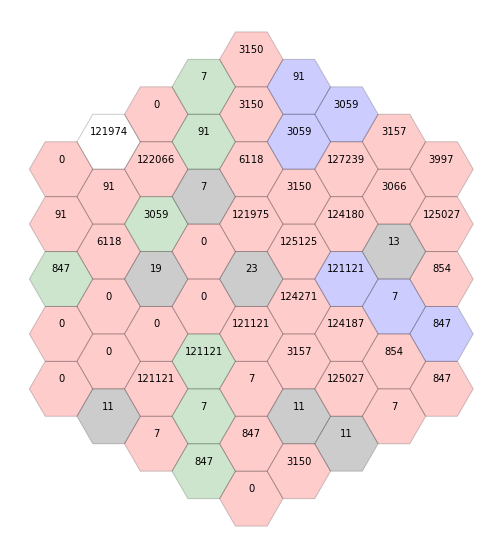

In [10]:
start = time.time()

point = {}
point_colour = {}
cols = ["k","b","r","g","w"]


lab_col= [2,2,3,2,2,
          0,2,2,2,2,4,
          2,2,2,0,3,2,2,
          3,3,3,2,2,0,3,3,
          2,2,2,2,0,2,2,2,2,
          2,0,2,2,2,2,1,1,
          0,2,2,1,2,2,1,
          2,2,1,0,2,2,
          2,1,2,2,2]

x=0

s = Optimize()


#Set up the variables
for i,j,k in itertools.product(range(-4,5),range(-4,5),range(-4,5)):
    if i+j+k !=0:
        continue
    point[(i,j,k)] = Int("x_%s_%s_%s" % (i+5, j+5,k+5))
    point_colour[(i,j,k)] = Int("c_%s_%s_%s" % (i+5, j+5,k+5))
    
    if int(lab_col[x]) in [1,3]:
        s += point_colour[(i,j,k)] == int(lab_col[x])
    else:
        s += point_colour[(i,j,k)] != 1
        s += point_colour[(i,j,k)] != 3
    x += 1

s.maximize(Sum([point[(x,y,z)] for x,y,z in point.keys() if x ==0]))
    
# Fixed points    
s += [point[(i,j,k)] > -1 for (i,j,k) in point.keys()]
s += [And(point_colour[(i,j,k)] >=0,point_colour[(i,j,k)] <5)  for (i,j,k) in point_colour.keys()]

s += point[(-1,4,-3)] == 7
s += point_colour[(-1,4,-3)] == 3

s += point[(-2,4,-2)] == 0
s += point_colour[(-2,4,-2)] == 2

s += point[(4,0,-4)] == 3997
s += point_colour[(4,0,-4)] == 2

s += point[(1,2,-3)] == 3059
s += point_colour[(1,2,-3)] == 1

s += point[(4,-2,-2)] == 854
s += point_colour[(4,-2,-2)] == 2

s += point[(2,-1,-1)] == 121121
s += point_colour[(2,-1,-1)] == 1

s += point[(-4,2,2)] == 847
s += point_colour[(-4,2,2)] == 3

s += point[(-3,0,3)] == 0
s += point_colour[(-3,0,3)] == 2

s += point[(-2,-2,4)] == 7
s += point_colour[(-2,-2,4)] == 2

s += point[(1,-3,2)] == 11
s += point_colour[(1,-3,2)] == 0
  
s += point[(3,-4,1)] == 7
s += point_colour[(3,-4,1)] == 2  
   
    
# constraints

# cols = ["k","b","r","g"]

for i,j,k in point.keys():
    s+= Implies(point_colour[(i,j,k)] == 0,  # black numbers = number of red numbers
               point[(i,j,k)] == Sum(                 
                   [If(point_colour[(x,y,z)] == 2,1,0) for x,y,z in point.keys() if (i==x or j==y or k==z) & ((i,j,k) != (x,y,z)) ])) 
  
    
    s+=  Implies(point_colour[(i,j,k)] == 1,  # blue number = max of green numbers 
        Or(point[(i,j,k)] ==0, *[And(point[(i,j,k)] == point[(x,y,z)],point_colour[(x,y,z)] == 3) for x,y,z in point.keys() if (i==x or j==y or k==z) & ((i,j,k) != (x,y,z))]))
    
    s+=  [Implies(And(point_colour[(x,y,z)] == 3, point_colour[(i,j,k)] ==1) ,point[(i,j,k)] >= point[(x,y,z)]) for x,y,z in point.keys() if (i==x or j==y or k==z) & ((i,j,k) != (x,y,z))]

    
    s+= Implies(point_colour[(i,j,k)] == 2, # red numbers = sum of blue numbers 
               point[(i,j,k)] == Sum(                 
                   [If(point_colour[(x,y,z)] == 1,point[(x,y,z)],0) for x,y,z in point.keys() if (i==x or j==y or k==z) & ((i,j,k) != (x,y,z)) ])
               )
    
    s+= Implies(point_colour[(i,j,k)] == 3, #green numbers = product of black numbers
               point[(i,j,k)] == Product(                 
                   [If(point_colour[(x,y,z)] == 0,point[(x,y,z)],1) for x,y,z in point.keys() if (i==x or j==y or k==z) & ((i,j,k) != (x,y,z)) ])
               )
  
if s.check() == sat:
    m = s.model()
    coord= [x for x in point.keys()]    
    color = [cols[m.evaluate(point_colour[x]).as_long()] for x in point_colour.keys()]
    labels = [m.evaluate(point[x]).as_long() for x in point.keys()] 
    answer = np.sum([m.evaluate(point[(i,j,k)]).as_long() for (i,j,k) in point.keys() if i==0])
    stop = time.time()
    print("Solved in {:.4f} seconds".format(stop-start))
    print("Sum is: {:,.0f}".format(answer))
    hex_print(coord,color,labels)

else:
    print("Failed")
   

In [4]:
url='https://www.janestreet.com/puzzles/solutions/october-2015-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print("Solution")
print("~~~~~~~~")
print(" ".join(x[7:8]))

Solution
~~~~~~~~
As it turns out there is only one valid solution to the puzzle, and the sum of the numbers in the center column is 256,391.   Congratulations to this month’s correct solvers, especially  Priscilla Cheung, this month’s randomly-chosen winner of a Jane Street t-shirt!


### Puzzle details
<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2015/11/hexagony_ans.png" width="400" >

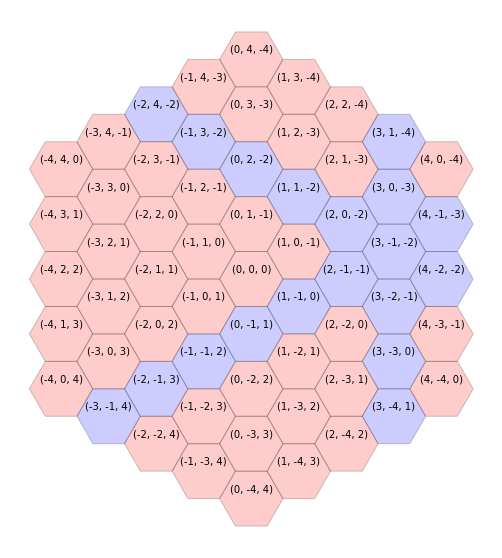

In [5]:
coord=[]
colors =[]
labels =[]

for i,j,k in itertools.product(range(-4,5),range(-4,5),range(-4,5)):
    if i+j+k !=0:
        continue
    coord.append([i,j,k])
    if i ==3 or j==-1 or k==-2:
        colors.append(["Blue"])
    else:
        colors.append("Red")
    labels.append((i,j,k))


hex_print(coord,colors,labels)

In [6]:
labs = [0,0,847,91,0,
 11,0,0,6118,91,0,
 7,121121,0,19,3059,122066,0,
 847,7,121121,0,0,7,91,7,
 0,847,7,121121,23,121975,6118,3150,3150,
 3150,11,3157,124271,125125,3150,3059,91,
 11,125027,124187,121121,124180,127239,3059,
 7,854,7,13,3066,3157,
 847,847,854,125027,3997]

lab_col= [2,2,3,2,2,0,2,2,2,2,4,2,2,2,0,3,2,2,3,3,3,2,2,0,3,3,2,2,2,2,0,2,2,2,2,2,0,2,2,2,2,1,1,0,2,2,1,2,2,1,2,2,1,0,2,2,2,1,2,2,2]